In [1]:
from keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from keras.layers import RepeatVector, Dense, Activation, Lambda
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.models import load_model, Model
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
import keras.backend as K
import numpy as np

import random
import matplotlib.pyplot as plt
%matplotlib inline


Using TensorFlow backend.


In [2]:
def softmax(x, axis=1):
    ndim = K.ndim(x)
    if ndim == 2:
        return K.softmax(x)
    elif ndim > 2:
        e = K.exp(x - K.max(x, axis=axis, keepdims=True))
        s = K.sum(e, axis=axis, keepdims=True)
        return e / s
    else:
        return ValueError('Cannot apply softmax to a tensor that is 1D')

In [3]:
# Defined shared layers as global variables
repeator = RepeatVector(30)
concatenator = Concatenate(axis=-1)
densor1 = Dense(10, activation = "tanh", name='tanh_dense')
densor2 = Dense(1, activation = "relu", name='relu_dense')
activator = Activation(softmax, name='attention_weights') # We are using a custom softmax(axis = 1) loaded in this notebook
dotor = Dot(axes = 1)

In [4]:
def one_step_attention(a, s_prev):
    s_prev = repeator(s_prev)
    concat = concatenator([a, s_prev])
    e = densor1(concat)
    energies = densor2(e)
    alphas = activator(energies)
    context = dotor([alphas, a])
    return context

In [5]:
n_a = 32
n_s = 64
post_activation_LSTM_cell = LSTM(n_s, return_state = True, name='post_LSTM')
output_layer = Dense(11, activation=softmax, name='output_layer_dense')

In [6]:
def model(Tx, Ty, n_a, n_s, human_vocab_size, machine_vocab_size):
    X = Input(shape=(Tx, human_vocab_size))
    s0 = Input(shape=(n_s, ), name='s0')
    c0 = Input(shape=(n_s, ), name='c0')
    s = s0
    c = c0
    
    outputs = []
    
    a = Bidirectional(LSTM(n_a, return_sequences=True), name='bidirectional')(X)
    #a = Bidirectional(LSTM(n_a), name='bidirectional')(X)
    for t in range(Ty):
        context = one_step_attention(a, s)
        s, _, c = post_activation_LSTM_cell(context, initial_state=[s, c])
        
        out = output_layer(_)
        
        outputs.append(out)
    model = Model(inputs=[X, s0, c0], outputs=outputs)
    return model

In [7]:
m = model(30, 10, n_a, n_s, 37, 30)

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
m.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 30, 37)       0                                            
__________________________________________________________________________________________________
s0 (InputLayer)                 (None, 64)           0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 30, 64)       17920       input_1[0][0]                    
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 30, 64)       0           s0[0][0]                         
                                                                 post_LSTM[0][0]                  
          

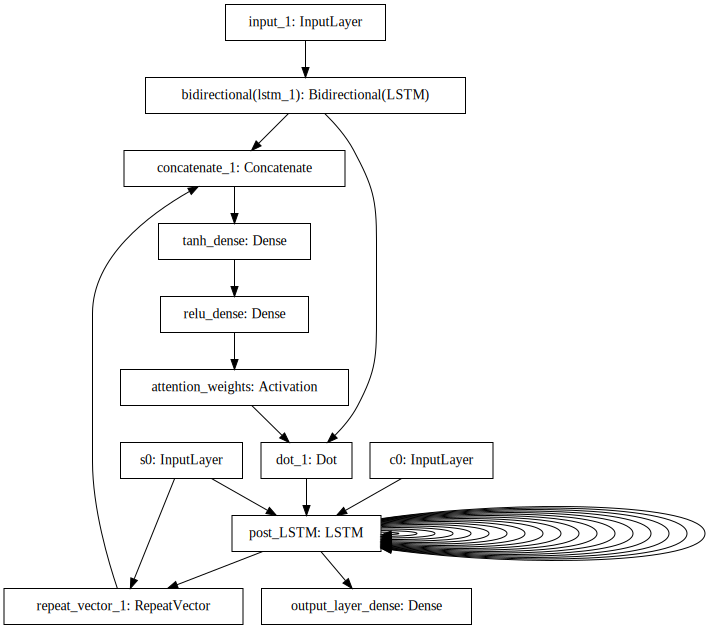

In [9]:
# ここでモデルを可視化する。
SVG(model_to_dot(m).create(prog='dot', format='svg'))